# Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

# Functions and constants

In [2]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray())
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

def get_transect(angle,npoints,x,y,z):
    transect_length  = np.min((np.max(y)-np.min(y),np.max(x)-np.min(x)))
    transect_pointss = np.linspace(-transect_length/2,transect_length/2,npoints)
    transect_pointsx = transect_pointss*np.cos(angle)+np.mean(x)
    transect_pointsy = transect_pointss*np.sin(angle)+np.mean(y)
    finterp2d = interp2d(x,y,z)
    transect_pointsz = np.diag(np.fliplr(finterp2d(transect_pointsx,transect_pointsy)))
    return transect_pointsx,transect_pointsy,transect_pointss,transect_pointsz

def get_regulargrid(x,y,z,npoints):
    if type(npoints)==tuple:
        if len(npoints)==2:
            x_grid = np.linspace(np.min(x),np.max(x),npoints[0])
            y_grid = np.linspace(np.min(y),np.max(y),npoints[1])
        else:
            return 'error: npoints as tuple must have len(npoints)==2'
    elif type(npoints)==int:
        x_grid = np.linspace(np.min(x),np.max(x),npoints)
        y_grid = np.linspace(np.min(y),np.max(y),npoints)        
    else:
        return 'error: npoints must be an int or a tuple of length 2'
    finterp2d = NearestNDInterpolator(list(zip(x, y)),z)
    X_grid,Y_grid = np.meshgrid(x_grid,y_grid)
    z_grid = finterp2d(X_grid,Y_grid)
    return x_grid,y_grid,z_grid

# Read data

In [3]:
data_geotiff = gdal.Open('output_AW3D30.tif')
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(data_geotiff)

In [4]:
data_netcdf = xr.open_dataset('e_era5-land_moda_sfc_20200101-20200131.nc')

In [5]:
data_mat = loadmat('seamount.mat')
x_mat    = np.ndarray.flatten(data_mat['x'])-180
y_mat    = np.ndarray.flatten(data_mat['y'])
z_mat    = np.ndarray.flatten(data_mat['z'])

# Analysis

Today all the analysis is done within the plotting cells!

# Plots

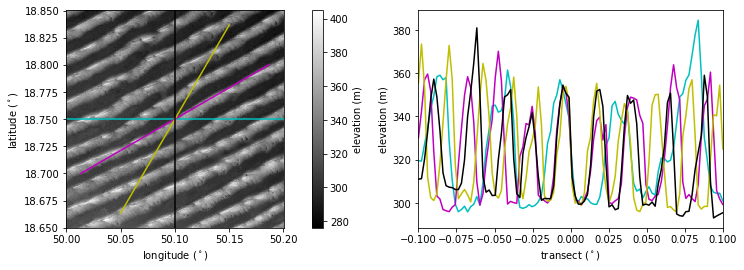

In [6]:
tempangles = np.linspace(-np.pi,-np.pi/2,4)
npoints = 100

colors = ['c','m','y','k']

fig = plt.gcf()

ax1 = plt.subplot(121)

plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff,cmap='binary_r')
plt.colorbar(label='elevation (m)')
plt.axis('square')

ax2 = plt.subplot(122)

for i in range(len(tempangles)):
    
    (transect_pointsx,
    transect_pointsy,
    transect_pointss,
    transect_pointsz) = get_transect(tempangles[i],
                                                                                       npoints,
                                                                                       lon_geotiff,
                                                                                       lat_geotiff,
                                                                                       z_geotiff)
    
    ax1.plot(transect_pointsx,transect_pointsy,c=colors[i])
    ax2.plot(transect_pointss,transect_pointsz,c=colors[i])
    
ax1.set_xlabel('longitude ($^\\circ$)')
ax1.set_ylabel('latitude ($^\\circ$)')
ax2.set_xlabel('transect ($^\\circ$)')
ax2.set_ylabel('elevation (m)')
ax2.set_xlim(transect_pointss[0],transect_pointss[-1])

fig.set_size_inches(12,4)

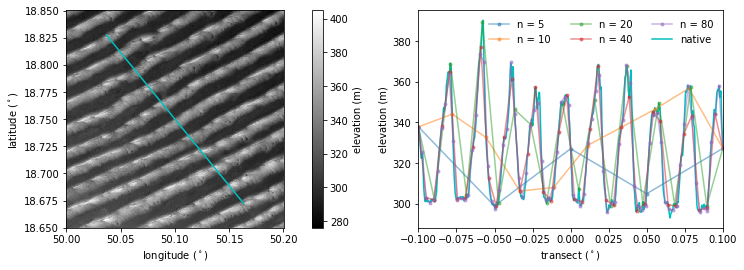

In [7]:
duneangle = -0.887087015161115
npoints = [5,10,20,40,80,len(lon_geotiff)]

ms = 3
al = 0.5

fig = plt.gcf()

ax1 = plt.subplot(121)

plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff,cmap='binary_r')
plt.colorbar(label='elevation (m)')
plt.axis('square')

ax2 = plt.subplot(122)

for i in range(len(npoints)):
    
    transect_pointsx,transect_pointsy,transect_pointss,transect_pointsz = get_transect(duneangle,
                                                                                       npoints[i],
                                                                                       lon_geotiff,
                                                                                       lat_geotiff,
                                                                                       z_geotiff)
    
    if i==0:
        ax1.plot(transect_pointsx,transect_pointsy,c='c')
    if i==len(npoints)-1:
        ax2.plot(transect_pointss,transect_pointsz,'c',label='native',zorder=-1)
    else:
        ax2.plot(transect_pointss,transect_pointsz,'-o',markersize=ms,alpha=al,label='n = %d'%npoints[i])
    
ax1.set_xlabel('longitude ($^\\circ$)')
ax1.set_ylabel('latitude ($^\\circ$)')
ax2.set_xlabel('transect ($^\\circ$)')
ax2.set_ylabel('elevation (m)')
ax2.set_xlim(transect_pointss[0],transect_pointss[-1])
ax2.legend(frameon=False,ncol=3)

fig.set_size_inches(12,4)

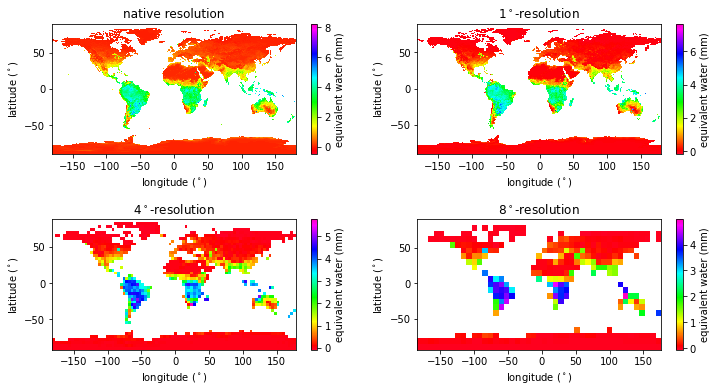

In [8]:
gridres = [1,4,8]

fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(data_netcdf.longitude,data_netcdf.latitude,data_netcdf.mean(dim='time').e*-1e+3,cmap='gist_rainbow')
plt.colorbar(label='equivalent water (mm)')
plt.xlabel('longitude ($^\\circ$)')
plt.ylabel('latitude ($^\\circ$)')
plt.title('native resolution')

for i in range(len(gridres)):
    
    tempdata = data_netcdf.interp(longitude=np.arange(-180,180,gridres[i]),latitude=np.arange(-90,90,gridres[i]))
    plt.subplot(222+i)
    plt.pcolormesh(tempdata.longitude,tempdata.latitude,tempdata.mean(dim='time').e*-1e+3,cmap='gist_rainbow')
    plt.colorbar(label='equivalent water (mm)')
    plt.xlabel('longitude ($^\\circ$)')
    plt.ylabel('latitude ($^\\circ$)')
    plt.title('%d$^\\circ$-resolution'%gridres[i])
    
plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(12,6)

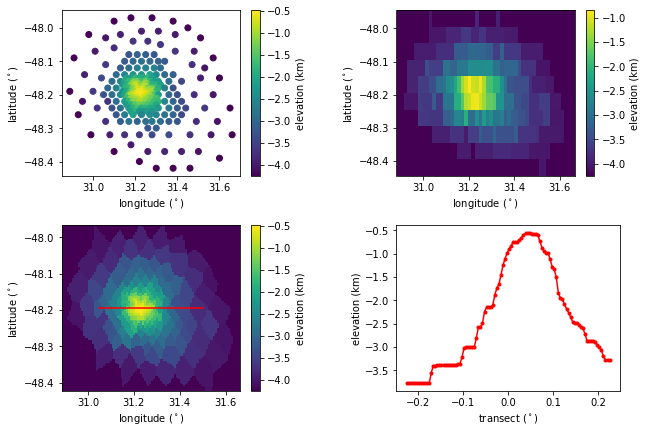

In [9]:
ms = 3
fig = plt.gcf()

plt.subplot(221)
plt.scatter(x_mat,y_mat,c=z_mat*1e-3)
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($^\\circ$)')
plt.ylabel('latitude ($^\\circ$)')

plt.subplot(222)
npoints = (50,10)
plt.pcolormesh(*get_regulargrid(x_mat,y_mat,z_mat*1e-3,npoints))
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($^\\circ$)')
plt.ylabel('latitude ($^\\circ$)')

npoints = 100
angle = 0
tempx,tempy,tempz = get_regulargrid(x_mat,y_mat,z_mat,npoints)
transect_pointsx,transect_pointsy,transect_pointss,transect_pointsz = get_transect(0,npoints,tempx,tempy,tempz)

plt.subplot(223)
plt.pcolormesh(tempx,tempy,tempz*1e-3)
plt.plot(transect_pointsx,transect_pointsy,'r')
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($^\\circ$)')
plt.ylabel('latitude ($^\\circ$)')

plt.subplot(224)
plt.plot(transect_pointss,transect_pointsz*1e-3,'-or',ms=ms)
plt.xlabel('transect ($^\\circ$)')
plt.ylabel('elevation (km)')

plt.subplots_adjust(hspace=0.3,wspace=0.5)
fig.set_size_inches(10,7)